In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import datetime as dt
import pickle

import seaborn as sns
sns.set()
from matplotlib import style
style.use('ggplot')

In [2]:
prices = pd.read_csv('sp500_closes.csv', index_col='Date', parse_dates=True)
prices.head()

,MMM,ABT,ABBV,ABMD,ACN,ATVI,ADBE,AMD,AAP,AES,...,WLTW,WYNN,XEL,XRX,XLNX,XYL,YUM,ZBH,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2013-01-02,79.758415,27.926201,27.193508,13.69,59.578766,10.310681,38.340000,2.53,71.585838,8.837808,...,78.928162,97.898666,21.486698,15.530575,31.753428,24.999222,42.287354,63.767414,20.332291,NaN
2013-01-03,79.665848,28.989225,26.968964,13.45,59.363071,10.367179,37.750000,2.49,71.585838,8.789598,...,79.734497,98.951675,21.423912,15.530575,31.693514,24.917400,42.551826,64.681076,20.360031,NaN
2013-01-04,80.254913,28.814959,26.628265,13.41,59.690914,10.517838,38.130001,2.59,72.701752,8.998492,...,79.711494,100.145653,21.502390,15.357772,31.248316,24.881042,43.017757,65.010742,20.942539,NaN
2013-01-07,80.355881,29.050213,26.682472,13.25,59.432095,10.527254,37.939999,2.67,72.454865,8.717291,...,79.481110,100.485619,21.274820,15.616977,31.119894,24.553778,42.746994,65.170853,20.840830,NaN
2013-01-08,80.364304,29.058924,26.101748,13.21,59.777180,10.348347,38.139999,2.67,71.269798,8.717291,...,79.089447,100.402710,21.314045,15.595379,30.486374,24.253788,40.952507,65.265068,20.424749,NaN


In [3]:
# prices.info()
prices.fillna(method='ffill', inplace=True)
prices.fillna(method='bfill', inplace=True) 
lookback = 14

In [4]:
def compute_momentum(prices, lookback=14):
    '''
    m[t] = p[t] / p[t - window] - 1
    '''
    momentum = (prices / prices.shift(lookback).values) - 1
    return momentum

def simple_moving_average(prices, lookback=14):
    rolling_mean = prices.rolling(window=lookback).mean()
    return rolling_mean

In [5]:
def compute_sma(prices, lookback=14, gen_plot=False):
    rolling_mean = simple_moving_average(prices, lookback)
    sma = prices / rolling_mean.values 
    return sma
#     sma_df =sma.to_frame(name=symbol)
#     return sma_df
sma = compute_sma(prices, lookback)

In [6]:
def compute_bbp(prices, lookback=14):
    roll_mean = prices.rolling(window=lookback, min_periods=lookback).mean()
    roll_std = prices.rolling(window=lookback, min_periods=lookback).std()
    lower_band = roll_mean - 2 * roll_std
    upper_band = roll_mean + 2 * roll_std
    bbp = (prices - lower_band) / (upper_band - lower_band)
    return bbp
bbp = compute_bbp(prices, lookback)

In [7]:
def compute_williams(df, lookback=14, symbol='BTC', gen_plot=False):
    close = df['Close']
    low = df['Low']
    high = df['High']
    roll_low = low.rolling(window=lookback, min_periods=lookback).min()
    roll_high = high.rolling(window=lookback, min_periods=lookback).max()
    percentR = -100 * (close - roll_low) / (roll_high - roll_low)
    
    if gen_plot:
        ax = percentR.plot(label='%R', color='g', title='Williams %R')
        ax.axhline(-20, ls='--')
        ax.axhline(-80, ls='--')
        ax.legend(loc='best')
        plt.show()
    percentR_df = percentR.to_frame(name=symbol)
    return percentR_df

def compute_sop(df, lookback=14, symbol='BTC', gen_plot=False):
#     df = get_df(st, et, colnames = ['Close', 'Low', 'High'])
    close = df['Close']
    low = df['Low']
    high = df['High']
    roll_low = low.rolling(window=lookback, min_periods=lookback).min()
    roll_high = high.rolling(window=lookback, min_periods=lookback).max()
    percentK = 100 * (close - roll_low) / (roll_high - roll_low)
    percentD = percentK.rolling(window=3, min_periods=3).mean()
    if gen_plot:
        ax = percentK.plot(label='%K', color='g', title='Stochastic Oscillator')
        percentD.plot(label='%D', color='r', ax=ax)
        ax.axhline(20, ls='--')
        ax.axhline(80, ls='--')
        ax.legend(loc='best')
        plt.show()
#         plt.savefig('sop.png')
#         ax = (close / close.ix[0]).plot(label = 'close')
#         (roll_low / close.ix[0]).plot(label = 'lowest low', ax=ax)
#         (roll_high / close.ix[0]).plot(label = 'highest high', ax=ax)
#         ax.legend(loc='best')
#         ax.set_ylim(1,3)
# 
#         plt.show()
#         plt.savefig('sop.png')
    percentD_df = percentD.to_frame(name=symbol)
    return percentD_df

In [8]:
sma = compute_sma(prices, lookback)
bbp = compute_bbp(prices, lookback)

In [9]:
daily_rets = prices.copy()
daily_rets.values[1:, :] = (prices.values[1:, :] / prices.values[:-1, :]) - 1
daily_rets.values[0, :] = np.nan                          
# daily_rets = daily_rets[1:-1]
# daily_rets = daily_rets.reset_index()
# daily_rets

In [10]:
def transpose_df(df):
    df = df[lookback-1:-1]
    df = df.reset_index()
    df = df.T
    header = df.iloc[0]
    df = df[1:].rename(columns=header)
    df = df.reset_index()
    return df
daily_rets = transpose_df(daily_rets)
sma = transpose_df(sma)
bbp = transpose_df(bbp)

In [11]:
# def transpose_df(df):
#     df = df[1:-1]
#     df = df.reset_index()
#     df = df.T
#     header = df.iloc[0]
#     df = df[1:].rename(columns=header)
#     df = df.reset_index()
#     return df
# daily_rets = transpose_df(daily_rets)
# sma = transpose_df(sma)
# bbp = transpose_df(bbp)

In [12]:
dates = daily_rets.columns[1:]
pred_steps = 30
data_start_date = dates[1]
data_end_date = dates[-1]

val_pred_start = dates[len(dates) - pred_steps]
val_pred_end = dates[len(dates) - 1]

train_pred_start = dates[len(dates) - 2*pred_steps]
train_pred_end = dates[len(dates) - pred_steps - 1]

enc_length = len(dates) - 2 * pred_steps
train_enc_start = dates[0]
train_enc_end = dates[enc_length - 1]

val_enc_start = dates[pred_steps]
val_enc_end = dates[pred_steps + enc_length - 1]

In [13]:
print('Train encoding:', train_enc_start, '-', train_enc_end)
print('Train prediction:', train_pred_start, '-', train_pred_end, '\n')
print('Val encoding:', val_enc_start, '-', val_enc_end)
print('Val prediction:', val_pred_start, '-', val_pred_end)

Train encoding: 2013-01-22 00:00:00 - 2019-07-15 00:00:00
Train prediction: 2019-07-16 00:00:00 - 2019-08-26 00:00:00 

Val encoding: 2013-03-06 00:00:00 - 2019-08-26 00:00:00
Val prediction: 2019-08-27 00:00:00 - 2019-10-08 00:00:00


In [14]:
def to_np(df, expand_dims=False):
    arr = np.array(df[df.columns[1:]].values, dtype=np.float)
    if expand_dims:
        arr = np.expand_dims(arr, axis=-1)
    return arr

In [15]:
series_array = to_np(daily_rets)
sma_array = to_np(sma, expand_dims=True)
bbp_array = to_np(bbp, expand_dims=True)

In [16]:
date_to_index = pd.Series(index=pd.Index([pd.to_datetime(c) for c in daily_rets.columns[1:]]),
                          data=[i for i in range(len(daily_rets.columns[1:]))])

def get_time_block_series(series_array, date_to_index, start_date, end_date):
    
    inds = date_to_index[start_date:end_date]
    return series_array[:,inds]

def transform_series_encode(series_array):
    
#     series_array = np.log1p(np.nan_to_num(series_array)) # filling NaN with 0
    series_array = np.nan_to_num(series_array) # filling NaN with 0
    series_mean = series_array.mean(axis=1).reshape(-1,1) 
    series_array = series_array - series_mean
    series_array = series_array.reshape((series_array.shape[0],series_array.shape[1], 1))
    
    return series_array, series_mean

def transform_series_decode(series_array, encode_series_mean):
    
#     series_array = np.log1p(np.nan_to_num(series_array)) # filling NaN with 0
    series_array = np.nan_to_num(series_array) # filling NaN with 0
    series_array = series_array - encode_series_mean
    series_array = series_array.reshape((series_array.shape[0],series_array.shape[1], 1))
    
    return series_array

In [17]:
exog_array = np.concatenate([sma_array, bbp_array], axis=-1)
exog_array.shape

(503, 1691, 2)

In [19]:
series_array.shape, sma_array.shape, bbp_array.shape

((503, 1691), (503, 1691, 1), (503, 1691, 1))

In [20]:
def get_data_encode_decode(series_array, exog_array, date_to_index, 
                           enc_start, enc_end, pred_start, pred_end):

    exog_inds = date_to_index[enc_start:pred_end]
    
    # sample of series from enc_start to enc_end  
    encoder_input_data = get_time_block_series(series_array, date_to_index, 
                                               enc_start, enc_end)
    encoder_input_data, encode_series_mean = transform_series_encode(encoder_input_data)
    
    # sample of series from pred_start to pred_end 
    decoder_target_data = get_time_block_series(series_array, date_to_index, 
                                                pred_start, pred_end)
    decoder_target_data = transform_series_decode(decoder_target_data, encode_series_mean)
    
    # we append a lagged history of the target series to the input data, 
    # so that we can train with teacher forcing
    lagged_target_history = decoder_target_data[:,:-1,:1]
    encoder_input_data = np.concatenate([encoder_input_data, lagged_target_history], axis=1)
    
    # we add the exogenous features corresponding to day after input series
    # values to the input data (exog should match day we are predicting)
    exog_input_data = exog_array[:,exog_inds,:][:,1:,:]
    encoder_input_data = np.concatenate([encoder_input_data, exog_input_data], axis=-1)
    
    return encoder_input_data, decoder_target_data

In [34]:
from keras.models import Model
from keras.layers import Input, Conv1D, Dense, Activation, Dropout, Lambda, Multiply, Add, Flatten, Concatenate, BatchNormalization
# from keras.optimizers import Adam
from keras import optimizers

In [44]:
# # convolutional layer parameters
# n_filters = 32
# filter_width = 2
# dilation_rates = [2**i for i in range(7)] 

# # define an input history series and pass it through a stack of dilated causal convolutions. 
# history_seq = Input(shape=(None, 1 + exog_array.shape[-1]))
# x = history_seq
# x_shortcut = None

# for i in range(len(dilation_rates)):
#     dilation_rate = dilation_rates[i]
# #     print(x.shape)
#     x = Conv1D(filters=n_filters, kernel_size=filter_width, padding='causal',
#                dilation_rate=dilation_rate, name='conv'+str(i))(x)
# #     if x_shortcut is None:
# #         x_shortcut = x
# #     x = BatchNormalization(name='bn'+str(i))(x)
# #     print(x.shape)
# #     print('--------------------')
# #     if (i % 2 != 0):
# #         x = Add()([x, x_shortcut])
# #         x_shortcut = x
#     x = Activation('relu')(x)

# x = Dense(128, activation='relu')(x)
# x = Dropout(.2)(x)
# x = Dense(1)(x)

# # extract the last 14 time steps as the training target
# def slice(x, seq_length):
#     return x[:,-seq_length:,:]

# pred_seq_train = Lambda(slice, arguments={'seq_length':pred_steps})(x)

# model = Model(history_seq, pred_seq_train)
# model.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_44 (InputLayer)        (None, None, 3)           0         
_________________________________________________________________
conv0 (Conv1D)               (None, None, 32)          224       
_________________________________________________________________
activation_263 (Activation)  (None, None, 32)          0         
_________________________________________________________________
conv1 (Conv1D)               (None, None, 32)          2080      
_________________________________________________________________
activation_264 (Activation)  (None, None, 32)          0         
_________________________________________________________________
conv2 (Conv1D)               (None, None, 32)          2080      
_________________________________________________________________
activation_265 (Activation)  (None, None, 32)          0   

In [45]:
# # convolutional operation parameters
# n_filters = 32 # 32 
# filter_width = 2
# dilation_rates = [2**i for i in range(8)] * 2 

# # define an input history series and pass it through a stack of dilated causal convolution blocks. 
# # Note the feature input dimension corresponds to the raw series and all exogenous features  
# history_seq = Input(shape=(None, 1 + exog_array.shape[-1]))
# x = history_seq

# skips = []
# for dilation_rate in dilation_rates:
    
#     # preprocessing - equivalent to time-distributed dense
#     x = Conv1D(32, 1, padding='same', activation='relu')(x) 
    
#     # filter convolution
#     x_f = Conv1D(filters=n_filters,
#                  kernel_size=filter_width, 
#                  padding='causal',
#                  dilation_rate=dilation_rate)(x)
    
#     # gating convolution
#     x_g = Conv1D(filters=n_filters,
#                  kernel_size=filter_width, 
#                  padding='causal',
#                  dilation_rate=dilation_rate)(x)
    
#     # multiply filter and gating branches
#     z = Multiply()([Activation('tanh')(x_f),
#                     Activation('sigmoid')(x_g)])
    
#     # postprocessing - equivalent to time-distributed dense
#     z = Conv1D(32, 1, padding='same', activation='relu')(z)
    
#     # residual connection
#     x = Add()([x, z])    
    
#     # collect skip connections
#     skips.append(z)

# # add all skip connection outputs 
# out = Activation('relu')(Add()(skips))

# # final time-distributed dense layers 
# out = Conv1D(128, 1, padding='same')(out)
# out = Activation('relu')(out)
# out = Dropout(.2)(out)
# out = Conv1D(1, 1, padding='same')(out)

# # extract the last 60 time steps as the training target
# def slice(x, seq_length):
#     return x[:,-seq_length:,:]

# pred_seq_train = Lambda(slice, arguments={'seq_length':pred_steps})(out)

# model = Model(history_seq, pred_seq_train)
# model.summary()

In [55]:
# convolutional layer parameters
n_filters = 4
filter_width = 2
dilation_rates = [2**i for i in range(4)] 

# define an input history series and pass it through a stack of dilated causal convolutions. 
# history_seq = Input(shape=(None, 1 + exog_array.shape[-1]))
# x = history_seq
# x_shortcut = None


x_hist = Input(shape=(None, 1))
x_sma = Input(shape=(None, 1))
x_bbp = Input(shape=(None, 1))
x_shortcut = [x_hist, x_sma, x_bbp]

for i in range(len(dilation_rates)):
    dilation_rate = dilation_rates[i]
#     print(x.shape)
    x_hist = Conv1D(filters=n_filters, kernel_size=filter_width, padding='causal',
               dilation_rate=dilation_rate, name='conv'+str(i))(x_hist)
    x_sma = Conv1D(filters=n_filters, kernel_size=filter_width, padding='causal',
               dilation_rate=dilation_rate, name='conv'+str(i))(x_sma)
    x_bbp = Conv1D(filters=n_filters, kernel_size=filter_width, padding='causal',
               dilation_rate=dilation_rate, name='conv'+str(i))(x_bbp)
#     if x_shortcut is None:
#         x_shortcut = x
#     x = BatchNormalization(name='bn'+str(i))(x)
#     print(x.shape)
    print(str(i) +' --------------------')
    if (i % 2 != 0):
        x_hist = Add()([x_hist, x_shortcut[0]])
        x_sma = Add()([x_sma, x_shortcut[1]])
        x_bbp = Add()([x_bbp, x_shortcut[2]])
        x_shortcut = [x_hist, x_sma, x_bbp]
    x_hist = Activation('relu')(x_hist)
    x_sma = Activation('relu')(x_sma)
    x_bbp = Activation('relu')(x_bbp)

print(x_hist.shape, x_sma.shape, x_bbp.shape)
out = Concatenate()([x_hist, x_sma, x_bbp])
# x = Add()([x_hist, x_sma, x_bbp])
print(out.shape)
out = Dense(128, activation='relu')(out)
out = Dropout(.2)(out)
out = Dense(1)(out)

# out = Conv1D(12, 1, padding='same')(x)
# out = Activation('relu')(out)
# out = Dropout(.2)(out)
# out = Conv1D(1, 1, padding='same')(out)

# extract the last 14 time steps as the training target
def slice(x, seq_length):
    return x[:,-seq_length:,:]

pred_seq_train = Lambda(slice, arguments={'seq_length':pred_steps})(out)

model = Model([x_hist, x_sma, x_bbp], pred_seq_train)
model.summary()

0 --------------------
1 --------------------
2 --------------------
3 --------------------
(?, ?, 4) (?, ?, 4) (?, ?, 4)
(?, ?, 12)


/nfs_shares/xzw0005_home/conda_envs/fastai/lib/python3.6/site-packages/keras/engine/network.py:190: UserWarning: Model inputs must come from `keras.layers.Input` (thus holding past layer metadata), they cannot be the output of a previous non-Input layer. Here, a tensor specified as input to your model was not an Input tensor, it was generated by layer activation_377.
Note that input tensors are instantiated via `tensor = keras.layers.Input(shape)`.
The tensor that caused the issue was: activation_377/Relu:0
  str(x.name))
/nfs_shares/xzw0005_home/conda_envs/fastai/lib/python3.6/site-packages/keras/engine/network.py:190: UserWarning: Model inputs must come from `keras.layers.Input` (thus holding past layer metadata), they cannot be the output of a previous non-Input layer. Here, a tensor specified as input to your model was not an Input tensor, it was generated by layer activation_378.
Note that input tensors are instantiated via `tensor = keras.layers.Input(shape)`.
The tensor that cau

ValueError: Graph disconnected: cannot obtain value for tensor Tensor("input_68:0", shape=(?, ?, 1), dtype=float32) at layer "input_68". The following previous layers were accessed without issue: []

In [ ]:
batch_size = 2**8
epochs = 20

encoder_input_data, decoder_target_data = \
    get_data_encode_decode(series_array, exog_array, date_to_index, 
                           train_enc_start, train_enc_end, train_pred_start, train_pred_end)

adam = optimizers.Adam(lr=1e-4)
model.compile(optimizer=adam, loss='mean_absolute_error')
history = model.fit(encoder_input_data, decoder_target_data,
                    batch_size=batch_size, validation_split=0.1,
                    epochs=epochs)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error Loss')
plt.title('Loss Over Time')
plt.legend(['Train','Valid'])

Train on 452 samples, validate on 51 samples
Epoch 1/80
452/452 [==============================] - 19s 43ms/step - loss: 0.0143 - val_loss: 0.0139
Epoch 2/80
452/452 [==============================] - 1s 1ms/step - loss: 0.0143 - val_loss: 0.0139
Epoch 3/80
452/452 [==============================] - 1s 1ms/step - loss: 0.0143 - val_loss: 0.0139
Epoch 4/80
452/452 [==============================] - 0s 820us/step - loss: 0.0143 - val_loss: 0.0139
Epoch 5/80
452/452 [==============================] - 0s 770us/step - loss: 0.0143 - val_loss: 0.0139
Epoch 6/80
452/452 [==============================] - 0s 764us/step - loss: 0.0143 - val_loss: 0.0139
Epoch 7/80
452/452 [==============================] - 0s 1ms/step - loss: 0.0143 - val_loss: 0.0139
Epoch 8/80
452/452 [==============================] - 1s 1ms/step - loss: 0.0143 - val_loss: 0.0139
Epoch 9/80
452/452 [==============================] - 1s 1ms/step - loss: 0.0143 - val_loss: 0.0139
Epoch 10/80
452/452 [==========================

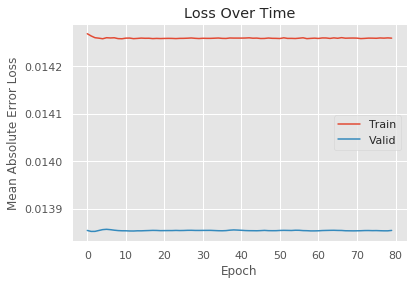

In [87]:
adam = optimizers.Adam(lr=1e-5)
model.compile(optimizer=adam, loss='mean_absolute_error')
history = model.fit(encoder_input_data, decoder_target_data,
                    batch_size=batch_size, validation_split=0.1,
                    epochs=80)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error Loss')
plt.title('Loss Over Time')
plt.legend(['Train','Valid'])

# Inference

In [88]:
def predict_sequence(input_tensor):

    history_tensor = input_tensor[:,:(-pred_steps+1),:]
    pred_sequence = np.zeros((1,pred_steps,1)) # initialize output (pred_steps time steps)  
    
    for i in range(pred_steps):
        
        # record next time step prediction (last time step of model output) 
        last_step_pred = model.predict(history_tensor)[0,-1,0]
        pred_sequence[0,i,0] = last_step_pred
        
        # add the next time step prediction along with corresponding exogenous features
        # to the history tensor
        last_step_exog = input_tensor[:,[(-pred_steps+1)+i],1:]
        last_step_tensor = np.concatenate([last_step_pred.reshape((1,1,1)), 
                                           last_step_exog], axis=-1)
        history_tensor = np.concatenate([history_tensor, last_step_tensor], axis=1)

    return pred_sequence

In [89]:
encoder_input_data, decoder_target_data = \
    get_data_encode_decode(series_array, exog_array, date_to_index, 
                           val_enc_start, val_enc_end, val_pred_start, val_pred_end)

In [90]:
def predict_and_plot(encoder_input_data, decoder_target_data, sample_ind, enc_tail_len=50):

    encode_tensor = encoder_input_data[[sample_ind],:,:] 
    pred_series = predict_sequence(encode_tensor)
    
    encode_series = encode_tensor[:,:(-pred_steps+1),0].reshape(-1,1)
    pred_series = pred_series.reshape(-1,1)   
    target_series = decoder_target_data[sample_ind,:,:1].reshape(-1,1) 
    
    encode_series_tail = np.concatenate([encode_series[-enc_tail_len:],target_series[:1]])
    x_encode = encode_series_tail.shape[0]
    
    plt.figure(figsize=(10,6))   
    
    plt.plot(range(1,x_encode+1),encode_series_tail)
    plt.plot(range(x_encode,x_encode+pred_steps),target_series,color='orange')
    plt.plot(range(x_encode,x_encode+pred_steps),pred_series,color='teal',linestyle='--')
    
    plt.title('Encoder Series Tail of Length %d, Target Series, and Predictions' % enc_tail_len)
    plt.legend(['Encoding Series','Target Series','Predictions'])

In [91]:
vis_ticks = ['GOOG', 'AAPL', 'XOM', 'HD', 'VZ', 'AMZN']
with open('data/sp500tickers.pickle', 'rb') as f:
    tickers = pickle.load(f)
len(tickers)

505

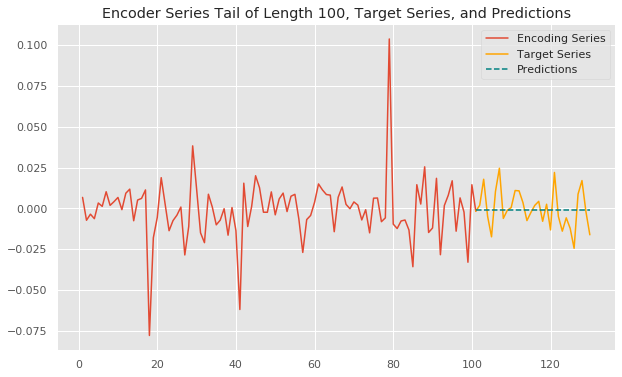

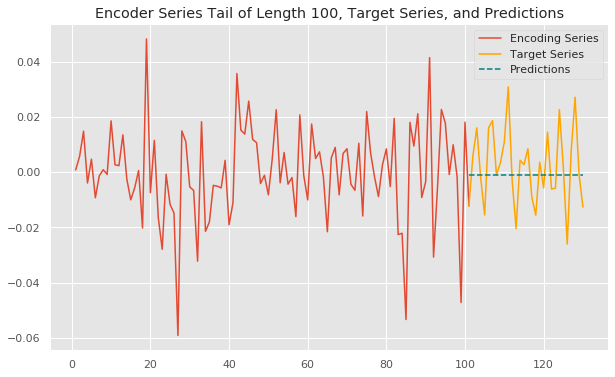

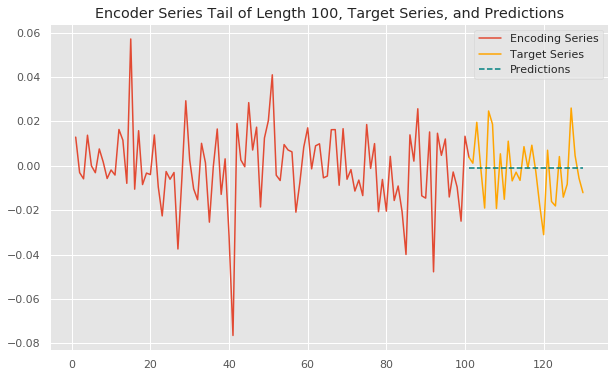

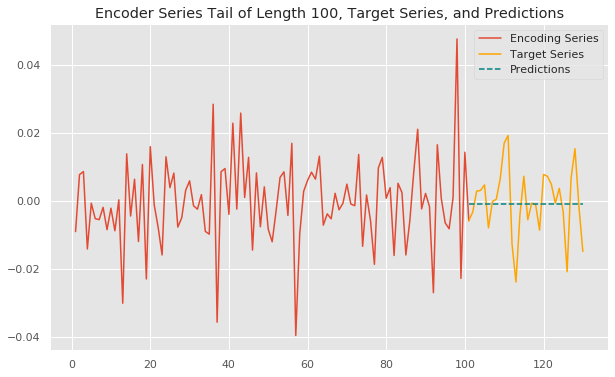

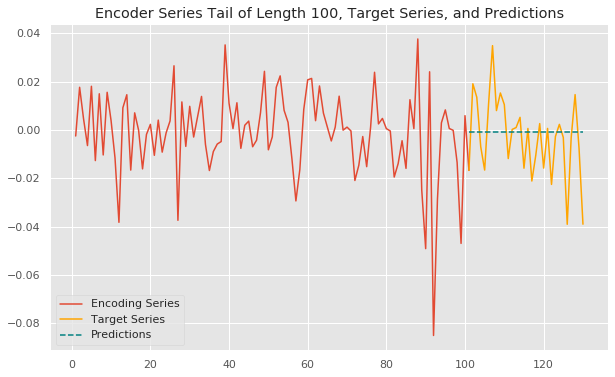

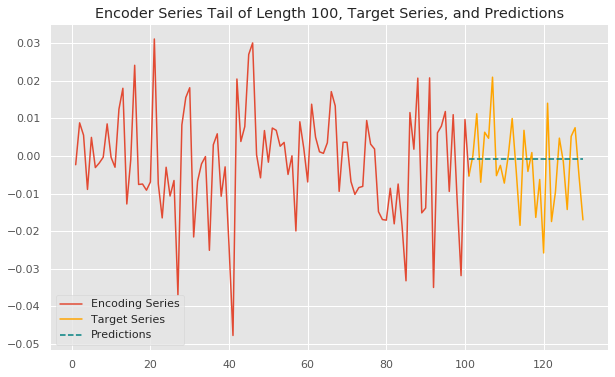

In [92]:
for ticker in vis_ticks:
    i = tickers.index(ticker)
    predict_and_plot(encoder_input_data, decoder_target_data, 
                 sample_ind=i, enc_tail_len=100)